## Keras Start Tutorial

### 1. Data

#### 1. text files =>  string tensors, then split into words.  Finally, the words need to be indexed & turned into integer tensors

#### 2. images read and decoded into integer tensors, converted to floating point and normalized to small values

#### 3. CSV data needs parsing, numerical turned to floating point tensors, categorical data indexed and converted to integer tensors. Each needs to be normalized to 0 mean and unit variance

### Data Loading as:
Numpy Arrays /n
/n tensorflow dataset objects  

*   Numpy Arrays
*   tensorflow dataset objects
*   python generators that yield batches of data

Keras utilities to help turn raw data on disk into a Dataset:
- `keras.utils.image_dataset_from_directory` turns image files sorted into
 class-specific folders into a labeled dataset of image tensors.
- `keras.utils.text_dataset_from_directory` does the same for text files.
- `tf.data.experimental.make_csv_dataset` to load structured data from CSV files.







In [1]:
!pip install tensorflow==2.13.0 -q

In [2]:
import os
import pathlib
import PIL
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers
from keras.models import Sequential

In [16]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

In [4]:
image_count = len(list(DATA_DIR.glob('*/*.jpg')))
print (image_count)

3670


In [5]:
DATA_DIR

PosixPath('/root/.keras/datasets/flower_photos')

In [6]:
!ls '/root/.keras/datasets/flower_photos'

daisy  dandelion  LICENSE.txt  roses  sunflowers  tulips


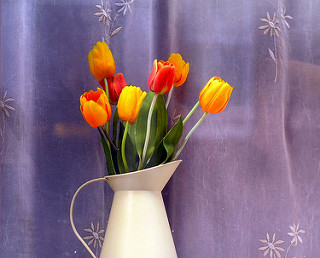

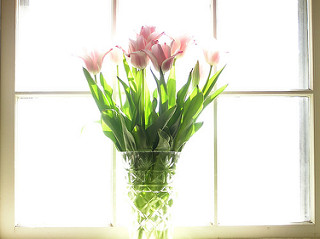

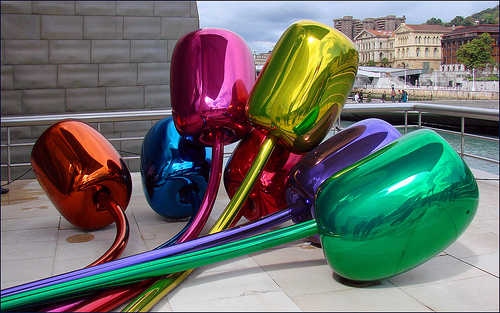

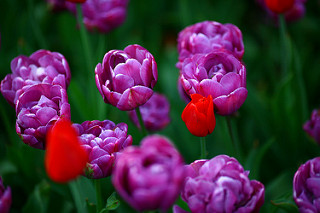

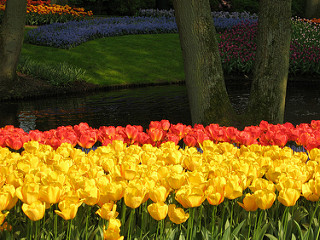

In [7]:
dasies = list(DATA_DIR.glob('daisy/*'))
tulips =  list(DATA_DIR.glob('tulips/*'))
for image_path in tulips[:5]:
  image = PIL.Image.open(image_path)
  display(image)

#### Load images using Keras - `tf.keras.utils.image_dataset_from_directory`

In [32]:
# Define variables

BATCH_SIZE = 32
IMG_SIZE = (180, 180)
AUTOTUNE = tf.data.AUTOTUNE


In [33]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=IMG_SIZE,
    batch_size = BATCH_SIZE

)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)


Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [22]:
class_names = train_ds.class_names
print(class_names)


In [26]:
train_ds.take(100)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

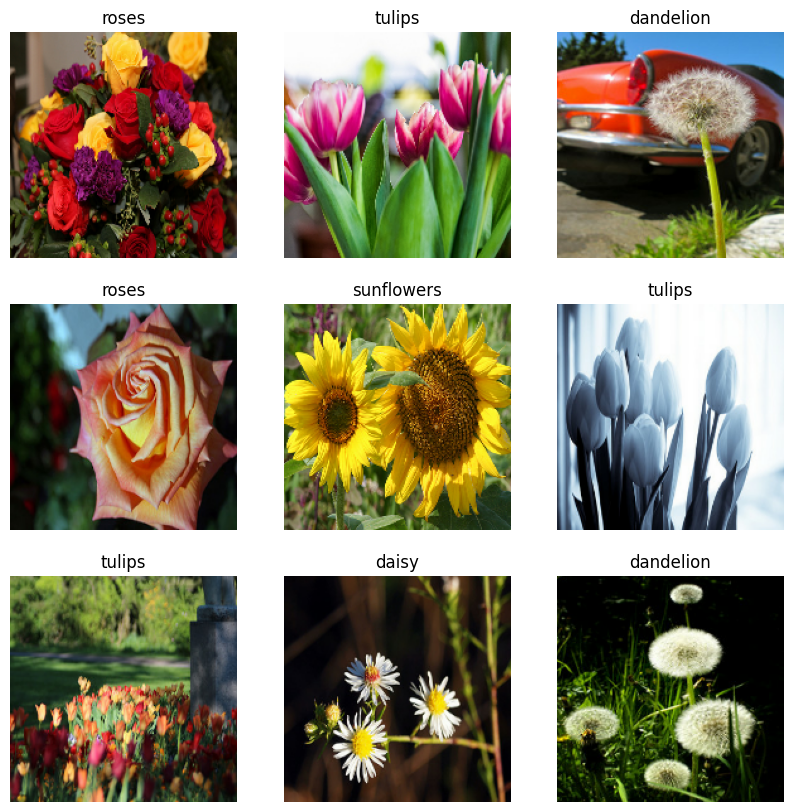

In [28]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(3):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")



In [29]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

You can call .numpy() on the image_batch and labels_batch tensors to convert them to a numpy.ndarray.

#### Buffered prefetching =  creating a buffer to store a certain number of data samples in memory while the model is training or evaluating on the previous batch.  
Prefetching the next batch of data into memory while the current batch is being processed, the model can overlap the time spent on I/O operations with the time spent on computation. This can lead to a significant reduction in the overall training time, as the model does not have to wait for I/O operations, which can be time-consuming.

Using buffered prefetching to ensure that I/O operations are non-blocking. Blocking I/O refers to the situation when the model has to wait for data to be read from disk before it can continue with computation

In [34]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

### Standardize The Data

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the [0, 1] range by using `tf.keras.layers.Rescaling`:

In [35]:
normalization_layer = layers.Rescaling(1./255)

### Create the Model
Sequential uses 3 convolution blocks:

(`tf.keras.layers.Conv2D`) with a max pooling layer

(`tf.keras.layers.MaxPooling2D`) in each of them

 There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function ('relu').

In [37]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(IMG_SIZE[0],IMG_SIZE[1], 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    # In a CNN architecture, as the model goes deeper (closer to the output layer), it is common to
    # increase the number of filters in the Conv2D layers. This allows the network to learn more sophisticated features and representations from the input images, enabling better performance in tasks like image classification. The increase in the number of filters helps the network capture high-level patterns and dependencies in the data, leading to more discriminative features for classification.
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    # Downsampling and Spatial Dimension Reduction: Max pooling layers reduce the spatial dimensions of the feature maps obtained after the convolutional layers. By taking the maximum value within a pooling window, the pooling layer downsamples the feature maps. This helps to reduce the computational complexity of the model and the memory requirement. Moreover, it allows the model to focus on the most important features and learn spatial invariances, making the model more robust to variations in the position of features within an image.
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])



#### The role of an optimizer is to minimize the loss function during the training process by updating the model's parameters (weights and biases) in the right direction. The goal is to find the optimal set of parameters that result in the best performance of the model on the given task.

In the context of TensorFlow and Keras, tf.keras.optimizers.Adam is one of the popular optimization algorithms available for training neural networks. Adam stands for "Adaptive Moment Estimation," and it combines the benefits of both AdaGrad and RMSprop algorithms.

Adam adapts the learning rate for each parameter during training. It uses moving averages of past gradients to adjust the learning rate, which allows it to handle different learning rates for different parameters. This adaptivity helps in faster convergence and more stable training.

Momentum: Adam incorporates a momentum term that helps the optimizer to continue moving in the direction of the previous updates. This feature helps overcome local minima and speeds up convergence.

Bias Correction: Adam performs bias correction during the early iterations of training, which is beneficial in situations where the moving averages are initialized close to zero.

In [38]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
              )


##### When using the `SparseCategoricalCrossentropy` loss with from_logits=True, you do not need to apply a softmax activation function to the model's output. The loss function internally performs the softmax transformation to obtain the probabilities and then calculates the cross-entropy.

#### The *Softmax activation* function is used in multi-class classification tasks to transform the raw logits into class probabilities. It enables us to interpret the model's output as a probability distribution, facilitates classification decision-making, and is commonly used in conjunction with the cross-entropy loss for training neural networks.

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [40]:
epochs = 5
history=model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/5
92/92 [==============================] - 141s 1s/step - loss: 1.4087 - accuracy: 0.4019 - val_loss: 1.1051 - val_accuracy: 0.5572
Epoch 2/5
92/92 [==============================] - 111s 1s/step - loss: 1.0289 - accuracy: 0.5998 - val_loss: 0.9720 - val_accuracy: 0.6090
Epoch 3/5
92/92 [==============================] - 108s 1s/step - loss: 0.8592 - accuracy: 0.6775 - val_loss: 1.0075 - val_accuracy: 0.6158
Epoch 4/5
92/92 [==============================] - 105s 1s/step - loss: 0.6930 - accuracy: 0.7371 - val_loss: 0.8810 - val_accuracy: 0.6512
Epoch 5/5
92/92 [==============================] - 123s 1s/step - loss: 0.4797 - accuracy: 0.8375 - val_loss: 0.9318 - val_accuracy: 0.6540


### Visualize Training Results

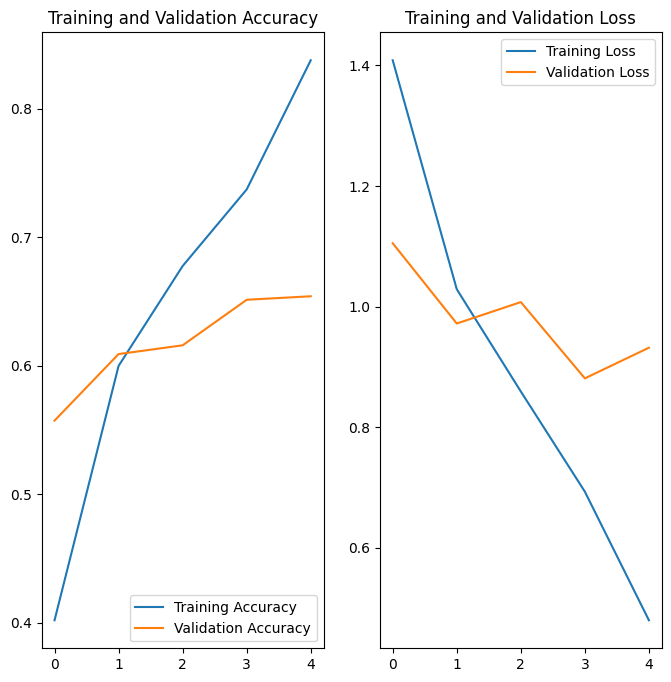

In [41]:
ACC = history.history['accuracy']
VAL_ACC = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


epochs_range = range(epochs)

plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, ACC, label='Training Accuracy')
plt.plot(epochs_range, VAL_ACC, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


### Overfitting =>  It means that the model will have a difficult time generalizing on a new dataset.

 the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of overfitting.

## Reduce Overfitting by:
1. Data Augmentation
2. Dropout


### 1. Data Augmentation

=>  generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

Implement data augmentation using the following Keras preprocessing layers: tf.keras.layers.RandomFlip, tf.keras.layers.RandomRotation, and tf.keras.layers.RandomZoom. These can be included inside your model like other layers, and run on the GPU.

In [47]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal",
                          input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1)

    ]
)

### Visualize Data Augmented Examples

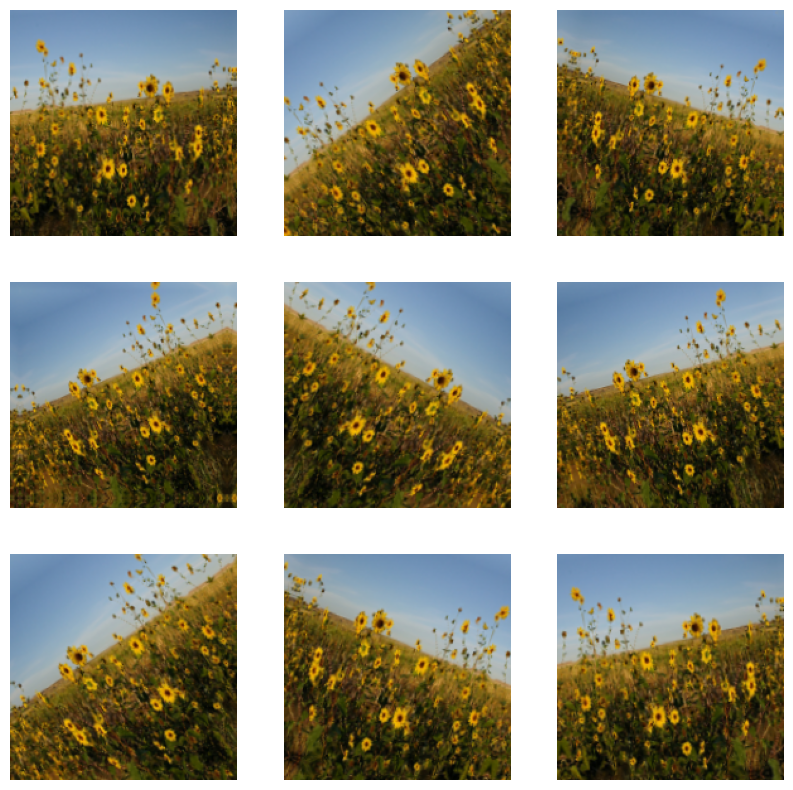

In [43]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


### 2. Dropout regularization to the network

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Create a new neural network with tf.keras.layers.Dropout before training it using the augmented images:

In [44]:
model2 = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name="outputs")
])

In [45]:
model2.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [48]:
model2.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [49]:
epochs = 5
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/5
92/92 [==============================] - 142s 2s/step - loss: 1.4095 - accuracy: 0.3876 - val_loss: 1.3854 - val_accuracy: 0.4428
Epoch 2/5
92/92 [==============================] - 128s 1s/step - loss: 1.1106 - accuracy: 0.5433 - val_loss: 1.1194 - val_accuracy: 0.5572
Epoch 3/5
92/92 [==============================] - 127s 1s/step - loss: 1.0092 - accuracy: 0.6069 - val_loss: 0.9875 - val_accuracy: 0.6022
Epoch 4/5
92/92 [==============================] - 123s 1s/step - loss: 0.9592 - accuracy: 0.6298 - val_loss: 0.9573 - val_accuracy: 0.6158
Epoch 5/5
92/92 [==============================] - 126s 1s/step - loss: 0.9119 - accuracy: 0.6349 - val_loss: 0.9232 - val_accuracy: 0.6281


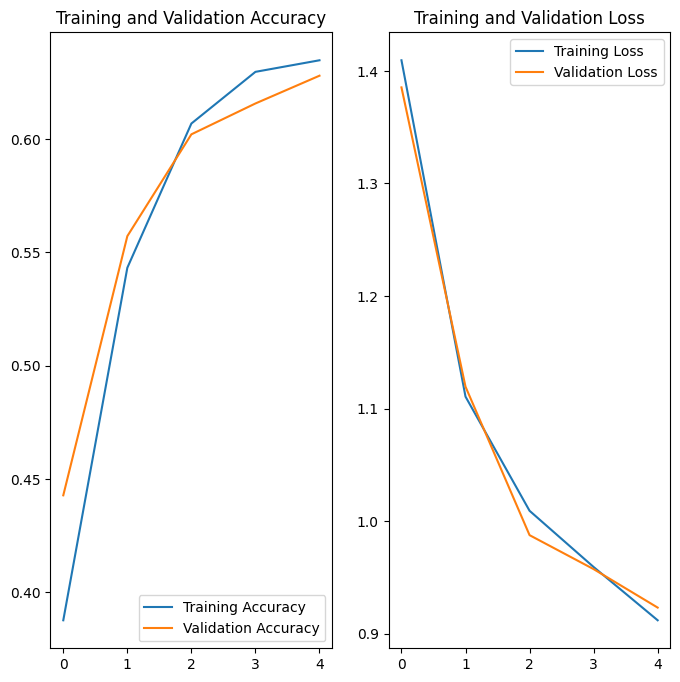

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


### Test Dataset



In [57]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=IMG_SIZE
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model2.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)



1/1 [==============================] - 0s 54ms/step
This image most likely belongs to tulips with a 59.70 percent confidence.


In [56]:
img = tf.keras.utils.load_img(
    sunflower_path, target_size=IMG_SIZE
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model2.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


1/1 [==============================] - 0s 46ms/step
This image most likely belongs to tulips with a 59.70 percent confidence.
